# 1 Data exploration

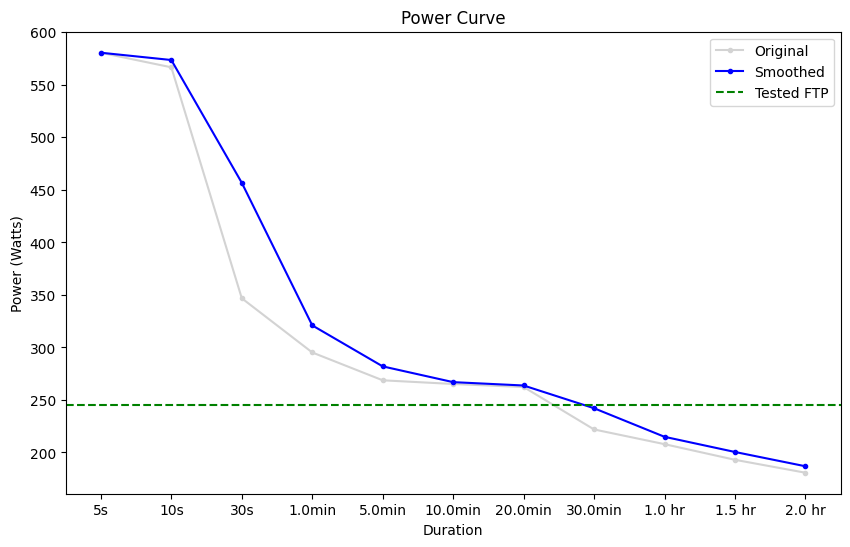

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from power_curve import PowerCurveAnalyzer

# Visualise Power curve to Sep 2022 when tested FTP was 241W
pca = PowerCurveAnalyzer()
power_curve = pca.create_power_curve('Ride', '2022-09-30', 90)
pca.plot_power_curve(power_curve, 245)

In [19]:
# Let's have a look st some of the outliers in the dataset

import numpy as np
import pandas as pd

# Print the power curve for the 'Ride' activity type
pca = PowerCurveAnalyzer()
power_curve = pca.create_power_curve('Ride', '2022-09-30', 90)
print(power_curve)


[(5, 580.6), (10, 566.7), (30, 346.8), (60, 295.2), (300, 268.7), (600, 265.2), (1200, 262.3), (1800, 221.9), (3600, 207.9), (5400, 193.0), (7200, 180.7)]


In [20]:

# Investigate outliers in the dataset
data = pd.read_csv('data/extended_activities.csv')

activity_type = 'Ride'
end_date = pd.to_datetime('2022-09-30')
start_date = end_date - pd.Timedelta(days=90)

# Convert 'Activity Date' column to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])

filtered_activities = data[(data['Activity Type'] == activity_type) & 
                            (data['Activity Date'] >= start_date) & 
                            (data['Activity Date'] <= end_date)]

ratios = []
i = 0

for column in filtered_activities.columns:
    if column.startswith('Maximum Power'):
        # Filter out zero values from the column
        non_zero_values = filtered_activities.loc[filtered_activities[column] != 0, column]

        # Calculate the average of non-zero values
        average_power = non_zero_values.mean()

        # Print the result
        print(f"{column}: Average Power = {average_power:.1f}")
        pair = power_curve[i]
        power_value = pair[1]
        ratio = average_power / power_value
        ratios.append(ratio)
        i += 1

print(ratios)


Maximum Power 5s: Average Power = 338.8
Maximum Power 10s: Average Power = 302.6
Maximum Power 30s: Average Power = 251.6
Maximum Power 1.0min: Average Power = 226.6
Maximum Power 5.0min: Average Power = 202.5
Maximum Power 10.0min: Average Power = 195.8
Maximum Power 20.0min: Average Power = 188.0
Maximum Power 30.0min: Average Power = 181.0
Maximum Power 1.0 hr: Average Power = 171.4
Maximum Power 1.5 hr: Average Power = 168.8
Maximum Power 2.0 hr: Average Power = 167.5
[0.5836067951483946, 0.5339778774623163, 0.7253991379833667, 0.767579517900442, 0.7535894070867529, 0.7383504008891006, 0.7168168228424663, 0.8155167097554612, 0.8243335611756666, 0.8746854182087342, 0.9268400664084118]


In [21]:
# Check whether removing outliers has a significant impact on the average power

column = 'Maximum Power 20.0min'

average_power = filtered_activities[column].mean()
print(f"{column}: Average Power = {average_power:.1f}")

filtered_activities_copy = filtered_activities[filtered_activities['Maximum Power 20.0min'] > filtered_activities['Maximum Power 20.0min'].mean() * 1.25].copy()
print(filtered_activities_copy)

filtered_activities_new = filtered_activities[~filtered_activities.index.isin(filtered_activities_copy.index)]

average_power = filtered_activities_new['Maximum Power 20.0min'].mean()
print(f"{column}: Average Power = {average_power:.1f}")

Maximum Power 20.0min: Average Power = 188.0
     Activity ID       Activity Date Activity Name Activity Type  \
165   7852682034 2022-09-23 00:35:50  Morning Ride          Ride   

     Elapsed Time  Distance  Max Heart Rate  Relative Effort  Commute  \
165          7048     46.35           148.0             58.0    False   

     Activity Gear  ... Maximum Power 10s  Maximum Power 30s  \
165  Scultura 5000  ...             566.7              346.8   

     Maximum Power 1.0min  Maximum Power 5.0min  Maximum Power 10.0min  \
165                 295.2                 268.7                  265.2   

     Maximum Power 20.0min  Maximum Power 30.0min  Maximum Power 1.0 hr  \
165                  262.3                  221.9                 172.1   

     Maximum Power 1.5 hr  Maximum Power 2.0 hr  
165                 144.9                   0.0  

[1 rows x 49 columns]
Maximum Power 20.0min: Average Power = 183.9


In [22]:
# Just a quick utility routine to calculate FTP the regulr way (i.e. 95% of 20min power or 100% or 1hr power)

from power_curve import PowerCurveAnalyzer

def calculate_ftp_from_powercurve(date):

    # Now test it against regular testing methods
    pca = PowerCurveAnalyzer()
    power_curve = pca.create_power_curve('Ride', date, 90)
 
    ftp_from_hour = next((y for x, y in power_curve if x == 60*60), None)
    ftp_from_20min = next((y for x, y in power_curve if x == 20*60), None) * 0.95

    print (f"FTP from 60min: {ftp_from_hour:.1f}")
    print (f"FTP from 20min: {ftp_from_20min:.1f}")

    return max(ftp_from_hour, ftp_from_20min)
    

## 2. Prepare the data for model training and evaluation

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual FTP')
    plt.ylabel('Predicted FTP')
    plt.title('Actual vs Predicted FTP: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
    plt.show()

In [24]:
# Remove unnecesary columns
def reduce_columns(data):

    # Remove columns that are not related to FTP
    data = data.drop(['Activity ID', 
                    'Activity Name', 
                    'Activity Type', 
                    'Commute',
                    'Activity Gear',
                    'Filename',
                    'Dirt Distance',
                    'Total Steps'
                    ], 
                    axis=1)

    return data

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the data
data = pd.read_csv('data/extended_activities.csv')

# Remove columns that are not related to FTP
data = reduce_columns(data)

# Add FTP data to the dataframe
ftp_data = pd.DataFrame({
            'Date': ['2017-06-28', '2020-09-18', '2021-01-31', '2022-09-23', '2023-01-05'],
            'FTP': [222*0.95, 238*0.95, 245*0.95, 262*0.95, 266*0.95]
        })

# Convert 'Date' columns to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
ftp_data['Date'] = pd.to_datetime(ftp_data['Date'])

In [26]:
# Checking the newly created 'ftp_data' dataset
ftp_data

,Date,FTP
0,2017-06-28,210.90
1,2020-09-18,226.10
2,2021-01-31,232.75
3,2022-09-23,248.90
4,2023-01-05,252.70


In [27]:
# Prepare the data for training a model

# Sort dataframes by date
data = data.sort_values(by='Activity Date')
ftp_data = ftp_data.sort_values(by='Date')

# Create a new dataframe to store the FTP values for each activity date
ftp_values = pd.merge_asof(data, ftp_data, left_on='Activity Date', right_on='Date', direction='backward')

# Drop the extra 'Date' column from ftp_data
ftp_values = ftp_values.drop(columns=['Date'])

# Remove outliers?


In [28]:
# Checking addition of FTP column to the 'ftp_values' dataset
print(ftp_values.columns)
print("Number of columns: ", len(ftp_values.axes[1]))

Index(['Activity Date', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Athlete Weight', 'Bike Weight', 'Moving Time',
       'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss',
       'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade',
       'Max Cadence', 'Average Cadence', 'Average Heart Rate', 'Average Watts',
       'Calories', 'Average Temperature', 'Total Work', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'Grade Adjusted Distance',
       'Average Elapsed Speed', 'Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min',
       'Maximum Power 10.0min', 'Maximum Power 20.0min',
       'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr',
       'Maximum Power 2.0 hr', 'FTP'],
      dtype='object')
Number of columns:  42


In [29]:
# Calculating correlation of dataset fields with 'FTP' field for possible reduction of model input variables
corr_with_FTP = ftp_values.corr()['FTP']

# Display the correlation of each field with 'FTP' field
corr_with_FTP.sort_values(ascending=False)

FTP                          1.000000
Activity Date                0.956790
Maximum Power 10.0min        0.509984
Maximum Power 20.0min        0.499645
Average Watts                0.486830
Maximum Power 5.0min         0.479790
Weighted Average Power       0.474910
Max Heart Rate               0.461392
Maximum Power 30.0min        0.453181
Average Heart Rate           0.379501
Calories                     0.325803
Maximum Power 1.0min         0.313581
Relative Effort              0.272601
Average Cadence              0.237277
Maximum Power 30s            0.210010
Max Grade                    0.183174
Total Work                   0.069989
Maximum Power 10s           -0.014976
Average Elapsed Speed       -0.026711
Elevation Low               -0.030625
Elevation High              -0.035553
Elevation Loss              -0.065179
Maximum Power 2.0 hr        -0.065500
Average Grade               -0.078292
Maximum Power 1.0 hr        -0.097289
Elevation Gain              -0.112156
Grade Adjust

## 3. Removing highly correlating features using correlation matrix

In [30]:
# Checking the correlation between columns (features) without FTP as target variable

# removing target variable FTP to keep only the input features
ftp_values_corr= ftp_values.drop(['FTP'],  axis=1)
# creating correlation matrix with absolute values
corr_df=ftp_values_corr.corr().abs()
# covering/masking upper triangle of the correlation matrix to remove only single feature from a pair
mask=np.triu(np.ones_like(corr_df, dtype=bool))
pair_corr_df = corr_df.mask(mask)
# showing the correlation matrix with only the lower triangle
pair_corr_df

,Activity Date,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Moving Time,Max Speed,Average Speed,...,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
Activity Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elapsed Time,0.161340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,0.310219,0.899910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Heart Rate,0.547256,0.241937,0.461963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative Effort,0.339247,0.029190,0.266405,0.739731,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Athlete Weight,0.408470,0.230515,0.281652,0.045721,0.246704,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bike Weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Moving Time,0.176155,0.984706,0.919560,0.239939,0.032177,0.218800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Speed,0.210473,0.253699,0.414933,0.421578,0.382041,0.055496,NaN,0.264050,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Speed,0.498252,0.429666,0.715449,0.712312,0.561481,0.428136,NaN,0.444637,0.545648,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Identifying variables having 90% or more correlation with other variables in order to remove them from the dataset
drop_feat = [i for i in pair_corr_df.columns if any(pair_corr_df[i] > 0.90)]
print(drop_feat)
print("Number of columns to drop: ", len(drop_feat))

['Elapsed Time', 'Distance', 'Moving Time', 'Average Speed', 'Elevation Gain', 'Average Watts', 'Calories', 'Total Work', 'Weighted Average Power', 'Power Count', 'Maximum Power 30s', 'Maximum Power 5.0min', 'Maximum Power 10.0min', 'Maximum Power 20.0min']
Number of columns to drop:  14


In [32]:
# Dropping one variable from the identified highly correlating feature pairs using the original dataset having FTP target variable
ftp_values_dimreduced = ftp_values.drop(drop_feat, axis=1)
print(ftp_values_dimreduced.columns)
print('Number of kept features and FTP= ', len(ftp_values_dimreduced.axes[1]))

Index(['Activity Date', 'Max Heart Rate', 'Relative Effort', 'Athlete Weight',
       'Bike Weight', 'Max Speed', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence',
       'Average Cadence', 'Average Heart Rate', 'Average Temperature',
       'Perceived Exertion', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'Grade Adjusted Distance',
       'Average Elapsed Speed', 'Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 1.0min', 'Maximum Power 30.0min', 'Maximum Power 1.0 hr',
       'Maximum Power 1.5 hr', 'Maximum Power 2.0 hr', 'FTP'],
      dtype='object')
Number of kept features and FTP=  28


In [33]:
# Calculating correlation of kept variables with 'FTP'
corr_with_FTP_dimreduced = ftp_values_dimreduced.corr()['FTP']

# Displaying the correlation of each kept field with 'FTP'
corr_with_FTP_dimreduced.sort_values(ascending=False)

FTP                          1.000000
Activity Date                0.956790
Max Heart Rate               0.461392
Maximum Power 30.0min        0.453181
Average Heart Rate           0.379501
Maximum Power 1.0min         0.313581
Relative Effort              0.272601
Average Cadence              0.237277
Max Grade                    0.183174
Maximum Power 10s           -0.014976
Average Elapsed Speed       -0.026711
Elevation Low               -0.030625
Elevation High              -0.035553
Elevation Loss              -0.065179
Maximum Power 2.0 hr        -0.065500
Average Grade               -0.078292
Maximum Power 1.0 hr        -0.097289
Grade Adjusted Distance     -0.166955
Max Speed                   -0.185418
Average Temperature         -0.190422
Maximum Power 5s            -0.250770
Maximum Power 1.5 hr        -0.261661
Max Cadence                 -0.348280
Athlete Weight                    NaN
Bike Weight                       NaN
Perceived Exertion                NaN
Prefer Perce

Mean Squared Error: 20.38342446045629
R² Score: 0.92988646562034


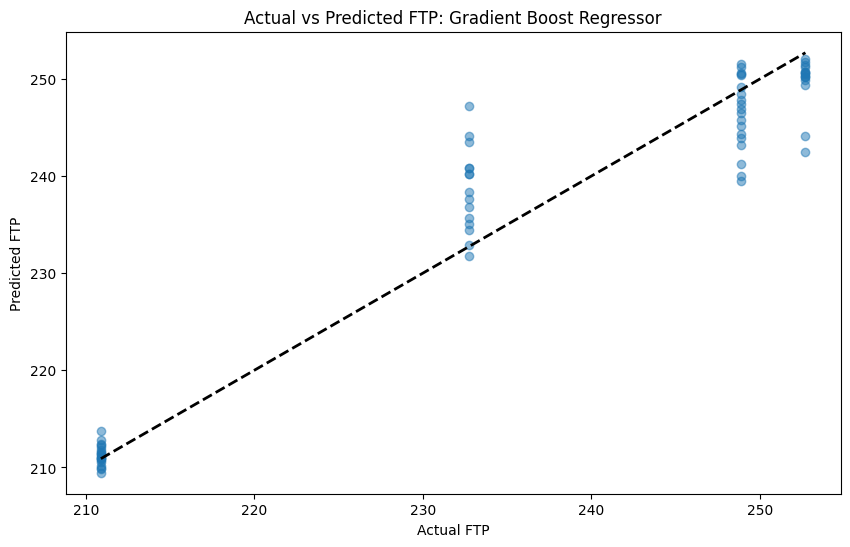

In [34]:
# Gradient Boost model

from sklearn.ensemble import GradientBoostingRegressor

data = ftp_values_dimreduced

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/Standardize features (if needed)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Create a Linear Regression model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Gradient Boost Regressor')